## Define the Pairwise Dynamics of 2 Spherobots Using 
### (Hx, Hy, Theta) or (H, Theta1, Theta2)

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 14 14:16:04 2020

@author: thomas
"""

#MODULES
import os,sys
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib notebook
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
from scipy.signal import savgol_filter
import pathlib
from matplotlib import animation
from IPython.display import display, Image, HTML

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

In [2]:
#CONSTANTS
cwd_PYTHON = os.getcwd()
PERIOD = 0.1
DT = 1.0e-2
RADIUSLARGE = 0.002
RADIUSSMALL = 0.001

#Lists
#RLength
R = ["3","5","6","7"]
SwimDirList = ["SSL", "LSL", "Stat"]

allData = []

#### Obtain Pos Data for all simulations
#### Limit time to first five oscillations

In [65]:
def StoreData(strR,strTheta, strConfig, strRe):
    #global axAll
    #Reset position data every Re
    pdData = []
    #Load position data
    #Periodic
    pdData = pd.read_csv(cwd_PYTHON+'/../Periodic/'+strR+'/'+strTheta+'/'+strConfig+'/'+strRe+'/pd.txt',delimiter = ' ')
    #Save only every 10 rows (Every period)
    pdData = pdData.iloc[::10]
    #Reindex so index corresponds to period number
    pdData = pdData.reset_index(drop=True)
    #Save ONLY the first 5 oscillations
    pdData = pdData[pdData['time'] <= 5*PERIOD]
    pdData = pdData.reset_index(drop=True)
    #Print pdData to make sure it has been done properly
    #print(pdData.head(6))
    #Create CM variables
    pdData['aXCM'] = 0.8*pdData.aXU + 0.2*pdData.aXL
    pdData['aYCM'] = 0.8*pdData.aYU + 0.2*pdData.aYL
    pdData['bXCM'] = 0.8*pdData.bXU + 0.2*pdData.bXL
    pdData['bYCM'] = 0.8*pdData.bYU + 0.2*pdData.bYL
    #Find separation distance and relative heading for LS
    pdData['H'], pdData['Hx'], pdData['Hy'], pdData['Theta'], pdData['Theta_a'], pdData['Theta_b'] = FindDistAngleBW(pdData['aXU'],pdData['aYU'],
                                                                  pdData['bXU'],pdData['bYU'],
                                                                  pdData['aXL'],pdData['aYL'],
                                                                  pdData['bXL'],pdData['bYL'])
    #print(pdData['H'].head(6))
    #print(pdData['Hx'].head(6))
    #print(pdData['Hy'].head(6))
    #print(180.0*pdData['Theta'].head(6)/np.pi)
    #print(180.0*pdData['Theta_a'].head(6)/np.pi)
    #print(180.0*pdData['Theta_b'].head(6)/np.pi)
    #sys.exit(0)
    #Calculate deltaH and deltaTheta
    pdData['dH'] = CalcDelta(pdData['H'])
    pdData['dHx'] = CalcDelta(pdData['Hx'])
    pdData['dHy'] = CalcDelta(pdData['Hy'])
    pdData['dTheta'] = CalcDeltaTheta(pdData['Theta'])
    pdData['dTheta_a'] = CalcDeltaTheta(pdData['Theta_a'])
    pdData['dTheta_b'] = CalcDeltaTheta(pdData['Theta_b'])
    #Renormalize Thetas
    pdData['Theta'] /= np.pi
    pdData['Theta_a'] /= np.pi
    pdData['Theta_b'] /= np.pi
    
    return pdData

#### Find Angle Between Swimmers (Account for Quadrant)

In [66]:
def FindDistAngleBW(aXU,aYU,bXU,bYU,aXL,aYL,bXL,bYL):
    #Find Distance b/w the 2 swimmers (Large Spheres)
    distXU = bXU - aXU
    distYU = bYU - aYU
    #H = distBW
    distBW = np.hypot(distXU,distYU)
    #Find relative heading Theta (angle formed by 2 swimmers)
    #1) Find normal orientation for swimmer A
    dist_aX = aXU - aXL
    dist_aY = aYU - aYL
    dist_a = np.hypot(dist_aX,dist_aY)
    norm_aX, norm_aY = dist_aX/dist_a, dist_aY/dist_a
    #Find normal orientation for swimmer B
    dist_bX = bXU - bXL
    dist_bY = bYU - bYL
    dist_b = np.hypot(dist_bX,dist_bY)
    norm_bX, norm_bY = dist_bX/dist_b, dist_bY/dist_b
    #2) Calculate Theta_a
    Theta_a = np.zeros(len(norm_aX))
    Theta_b = np.zeros(len(norm_bX))
    for idx in range(len(norm_aX)):
        if(norm_aY[idx] >= 0.0):
            Theta_a[idx] = np.arccos(norm_aX[idx])
        else:
            Theta_a[idx] = -1.0*np.arccos(norm_aX[idx])+2.0*np.pi
        if(norm_bY[idx] >= 0.0):
            Theta_b[idx] = np.arccos(norm_bX[idx])
        else:
            Theta_b[idx] = -1.0*np.arccos(norm_bX[idx])+2.0*np.pi
    #print('Theta_a = ',Theta_a*180.0/np.pi)
    #3) Rotate A and B ccw by 2pi - Theta_a
    Angle = 2.0*np.pi - Theta_a
    #print('Angle = ',Angle*180.0/np.pi)
    #Create rotation matrix
    rotationMatrix = np.zeros((len(Angle),2,2))
    rotationMatrix[:,0,0] = np.cos(Angle)
    rotationMatrix[:,0,1] = -1.0*np.sin(Angle)
    rotationMatrix[:,1,0] = np.sin(Angle)
    rotationMatrix[:,1,1] = np.cos(Angle)
    #print('rotationMatrix[-1] = ',rotationMatrix[10,:,:])
    #Create swimmer position arrays
    pos_a = np.zeros((len(norm_aX),2))
    pos_b = np.zeros((len(norm_bX),2))
    pos_a[:,0],pos_a[:,1] = norm_aX,norm_aY
    pos_b[:,0],pos_b[:,1] = norm_bX,norm_bY
    #print('pos_a = ',pos_a)
    #print('pos_b = ',pos_b)
    #Apply rotation operator
    rotpos_a, rotpos_b = np.zeros((len(norm_aX),2)), np.zeros((len(norm_bX),2))
    for idx in range(len(norm_aX)):
        #print('pos_a = ',pos_a[idx,:])
        #print('pos_b = ',pos_b[idx,:])
        #print('rotationMatrix = ',rotationMatrix[idx])
        rotpos_a[idx,:] = rotationMatrix[idx,:,:].dot(pos_a[idx,:])
        rotpos_b[idx,:] = rotationMatrix[idx,:,:].dot(pos_b[idx,:])
        #print('rotpos_a = ',rotpos_a[idx,:])
        #print('rotpos_b = ',rotpos_b[idx,:])
    #print('rotpos_a = ',rotpos_a)
    #print('rotpos_b = ',rotpos_b)
    #Calculate angleBW
    angleBW = np.zeros(len(norm_bY))
    for idx in range(len(norm_bY)):
        #angleBW[idx] = np.arccos(rotpos_a[idx,:].dot(rotpos_b[idx,:]))
        if(rotpos_b[idx,1] >= 0.0):
            angleBW[idx] = np.arccos(rotpos_a[idx,:].dot(rotpos_b[idx,:]))
        else:
            angleBW[idx] = -1.0*np.arccos(rotpos_a[idx,:].dot(rotpos_b[idx,:]))+2.0*np.pi
        
    #print('angleBW = ',angleBW*180/np.pi)
    
    return (distBW/RADIUSSMALL, distXU/RADIUSSMALL, distYU/RADIUSSMALL, angleBW, Theta_a, Theta_b)

In [5]:
def CalcDelta(data):
    #Calculate the change in either H or Theta for every period
    delta = data.copy()
    delta[0] = 0.0
    for idxPer in range(1,len(delta)):
        delta[idxPer] = data[idxPer] - data[idxPer-1]
        
    return delta

In [67]:
def CalcDeltaTheta(data):
    #Calculate the change in either H or Theta for every period
    delta = data.copy()
    delta[0] = 0.0
    for idxPer in range(1,len(delta)):
        #Check to see if angle has jumped from 2pi to 0 or vice versa
        if(data[idxPer] > data[idxPer-1]):
            sq = (data[idxPer] - data[idxPer-1])**2.0
            sq_2pi = (data[idxPer] - data[idxPer-1]-2.0*np.pi)**2.0
            delta[idxPer] = min(sq,sq_2pi)
        else:
            sq = (data[idxPer] - data[idxPer-1])**2.0
            sq_2pi = (data[idxPer] - data[idxPer-1]+2.0*np.pi)**2.0
            delta[idxPer] = min(sq,sq_2pi)
        #delta[idxPer] = data[idxPer] - data[idxPer-1]
        
    return delta/np.pi

#### Create dataframe of all pos data for all time for all sims

In [68]:
#The main goal of this script is to create an H-Theta Phase Space of all
#simulations for every period elapsed.
#Example: 20s of sim time = 200 periods. 200 H-Theta Plots
#We may find that we can combine the H-Theta data after steady state has been reached
#1) For each simulation, store position data for every period (nothing in between)
#2) Calculate separation distance between large spheres (H)
#3) Calculate relative heading (Theta)
#4) Calculate deltaH and deltaTheta (change after one Period)
#5) Plot H vs Theta (Polar) for each period

count = 0
for idxR in range(len(R)):
    cwd_R = cwd_PYTHON + '/../Periodic/' + R[idxR]
    dirsTheta = [d for d in os.listdir(cwd_R) if not d.startswith('.')]
    for Theta in dirsTheta:
        cwd_THETA = cwd_R + '/' + Theta
        dirsConfig = [d for d in os.listdir(cwd_THETA) if not d.startswith('.')]
        for Config in dirsConfig:
            for idxRe in range(len(SwimDirList)):
                if(idxRe == 2):
                    count += 1
print('count = ',count)
    
allData = [[[] for a in range(count)] for b in range(len(SwimDirList))] #[None]*(count)

#For each Reynolds number (aka Swim Direction)
for idxRe in range(len(SwimDirList)):
    count = 0
    #dict_allData = {'Hx':[],'Hy':[],'Theta':[],'dHx':[],'dHy':[],'dTheta':[],'time':[]}
    #df_allData = pd.DataFrame(data=dict_allData)
    #For each Initial Separation Distance
    #H(0) = Rval*R; R = radius of large sphere = 0.002m = 2mm
    for idxR in range(len(R)):
        cwd_R = cwd_PYTHON + '/../Periodic/' + R[idxR]
        #For each orientation at the specified length
        dirsTheta = [d for d in os.listdir(cwd_R) if not d.startswith('.')]
        for Theta in dirsTheta:
            cwd_THETA = cwd_R + '/' + Theta
            #For each configuration
            dirsConfig = [d for d in os.listdir(cwd_THETA) if not d.startswith('.')]
            for Config in dirsConfig:
                print(R[idxR]+'\t'+Theta+'\t'+Config)
                allData[idxRe][count] = StoreData(R[idxR],Theta,Config,SwimDirList[idxRe])
                #simData = allData[idxRe][count].copy()
                #simData['Hx'] /= RADIUSLARGE
                #simData['Hy'] /= RADIUSLARGE
                #simData['Theta'] /= np.pi
                #simData['dHx'] /= RADIUSLARGE
                #simData['dHy'] /= RADIUSLARGE
                #simData['dTheta'] /= np.pi
                #dict_sim = {'Hx':simData['Hx'],'Hy':simData['Hy'],'Theta':simData['Theta'],
                 #           'dHx':simData['dHx'],'dHy':simData['dHy'],'dTheta':simData['dTheta'],'time':simData['time']}
                #df_sim = pd.DataFrame(data=dict_sim)
                #df_allData = pd.concat([df_allData,df_sim],ignore_index=True)
                count += 1        
    #df_allData.to_csv(cwd_PYTHON+'/AllData_'+SwimDirList[idxRe]+'.csv',index=False,sep=' ')
print('Storing Data is complete! Onto Analysis')

count =  74
3	PI1	Anti
3	PI1	Parallel
3	PI1	PerpL
3	PI1	PerpS
3	PI2	Anti
3	PI2	Parallel
3	PI2	PerpL
3	PI2	PerpS
3	PI3	Anti
3	PI3	Parallel
3	PI3	PerpL
3	PI3	PerpS
3	PI4	PerpL
3	PI4	PerpS
5	PI0	Anti
5	PI0	Parallel
5	PI0	PerpL
5	PI0	PerpS
5	PI1	Anti
5	PI1	Parallel
5	PI1	PerpL
5	PI1	PerpS
5	PI2	Anti
5	PI2	Parallel
5	PI2	PerpL
5	PI2	PerpS
5	PI3	Anti
5	PI3	Parallel
5	PI3	PerpL
5	PI3	PerpS
5	PI4	Anti
5	PI4	Parallel
5	PI4	PerpL
5	PI4	PerpS
6	PI0	Anti
6	PI0	Parallel
6	PI0	PerpL
6	PI0	PerpS
6	PI1	Anti
6	PI1	Parallel
6	PI1	PerpL
6	PI1	PerpS
6	PI2	Anti
6	PI2	Parallel
6	PI2	PerpL
6	PI2	PerpS
6	PI3	Anti
6	PI3	Parallel
6	PI3	PerpL
6	PI3	PerpS
6	PI4	Anti
6	PI4	Parallel
6	PI4	PerpL
6	PI4	PerpS
7	PI0	Anti
7	PI0	Parallel
7	PI0	PerpL
7	PI0	PerpS
7	PI1	Anti
7	PI1	Parallel
7	PI1	PerpL
7	PI1	PerpS
7	PI2	Anti
7	PI2	Parallel
7	PI2	PerpL
7	PI2	PerpS
7	PI3	Anti
7	PI3	Parallel
7	PI3	PerpL
7	PI3	PerpS
7	PI4	Anti
7	PI4	Parallel
7	PI4	PerpL
7	PI4	PerpS
3	PI1	Anti
3	PI1	Parallel
3	PI1	PerpL
3	PI1	PerpS
3	PI2	Anti
3	P

#### Plot The Phase Space in 2D plane slices
##### (Hx, Hy) (Hx, Theta), (Hy, Theta)

data length =  74


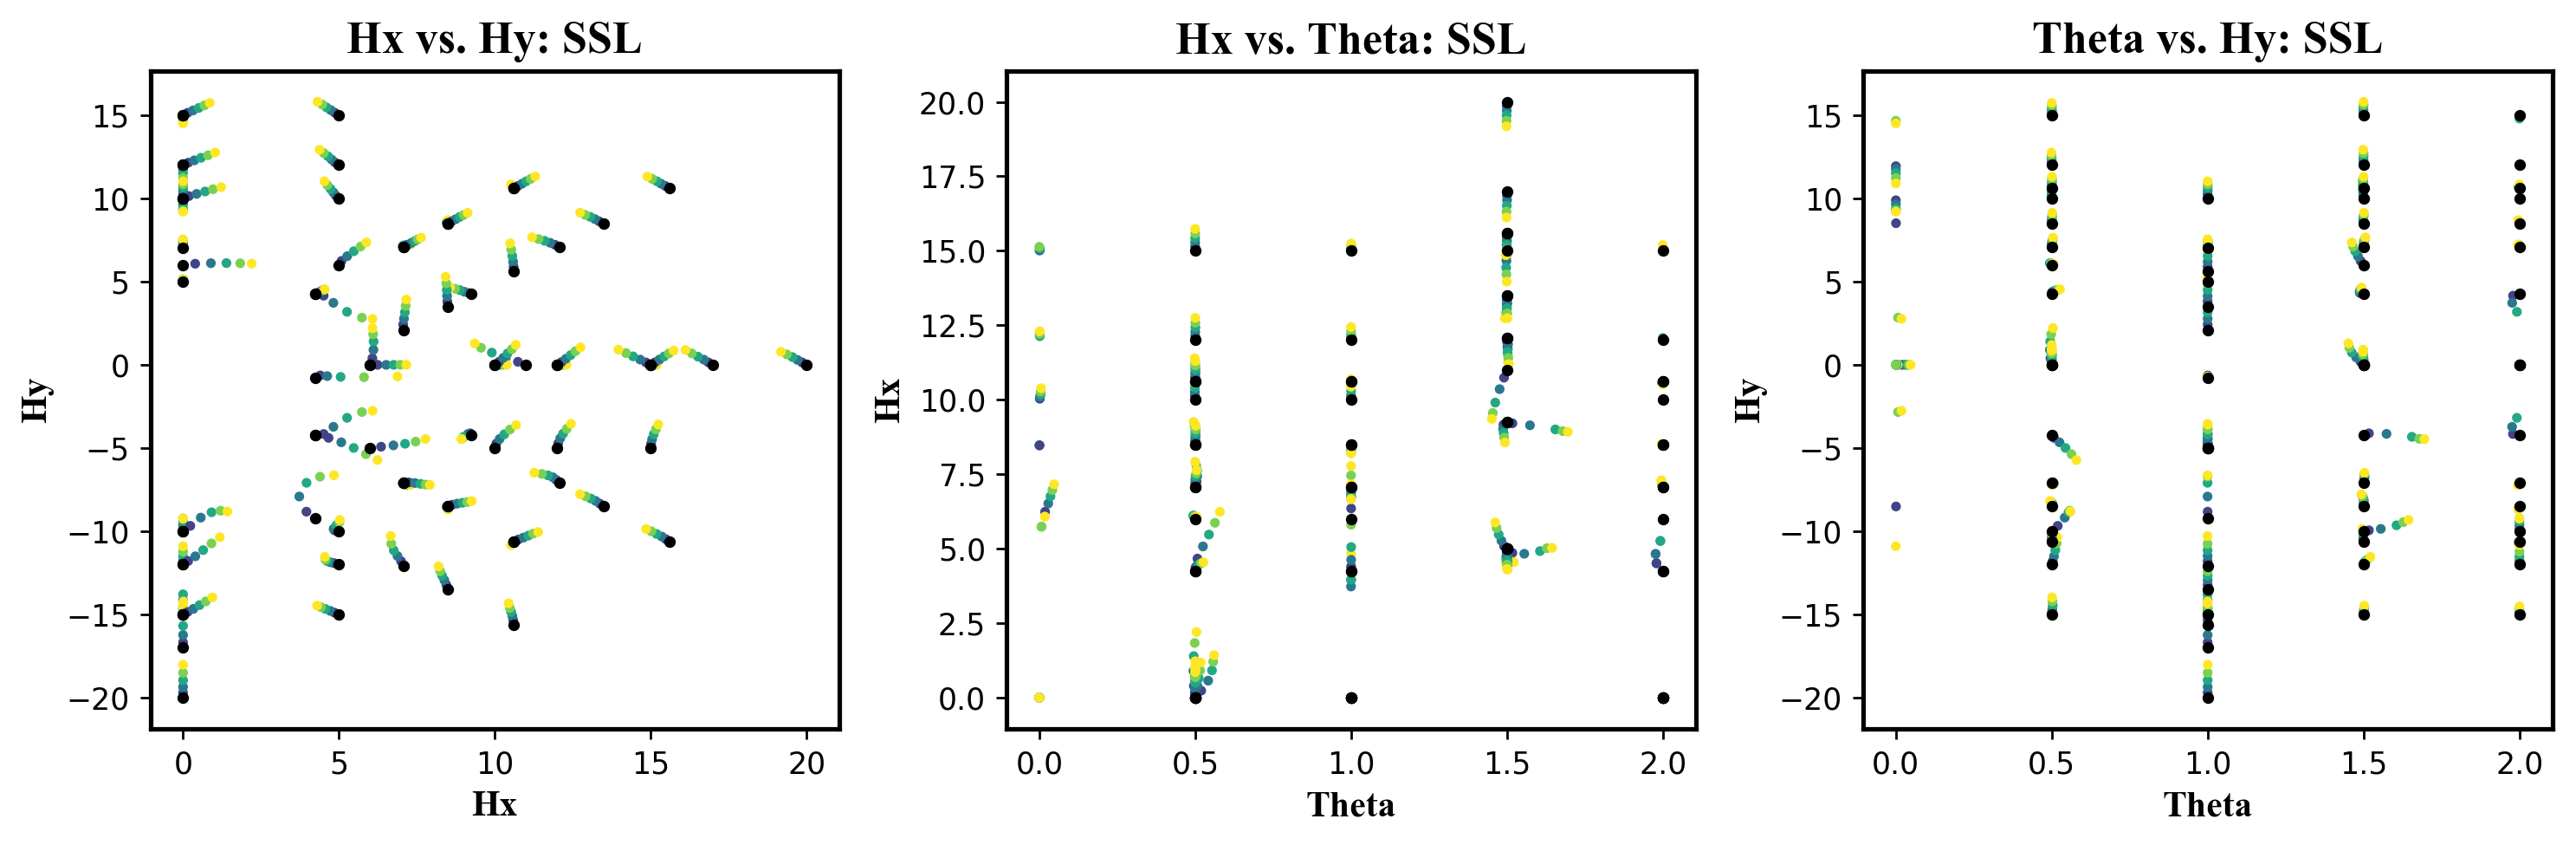

About to exit PlotAll
data length =  74


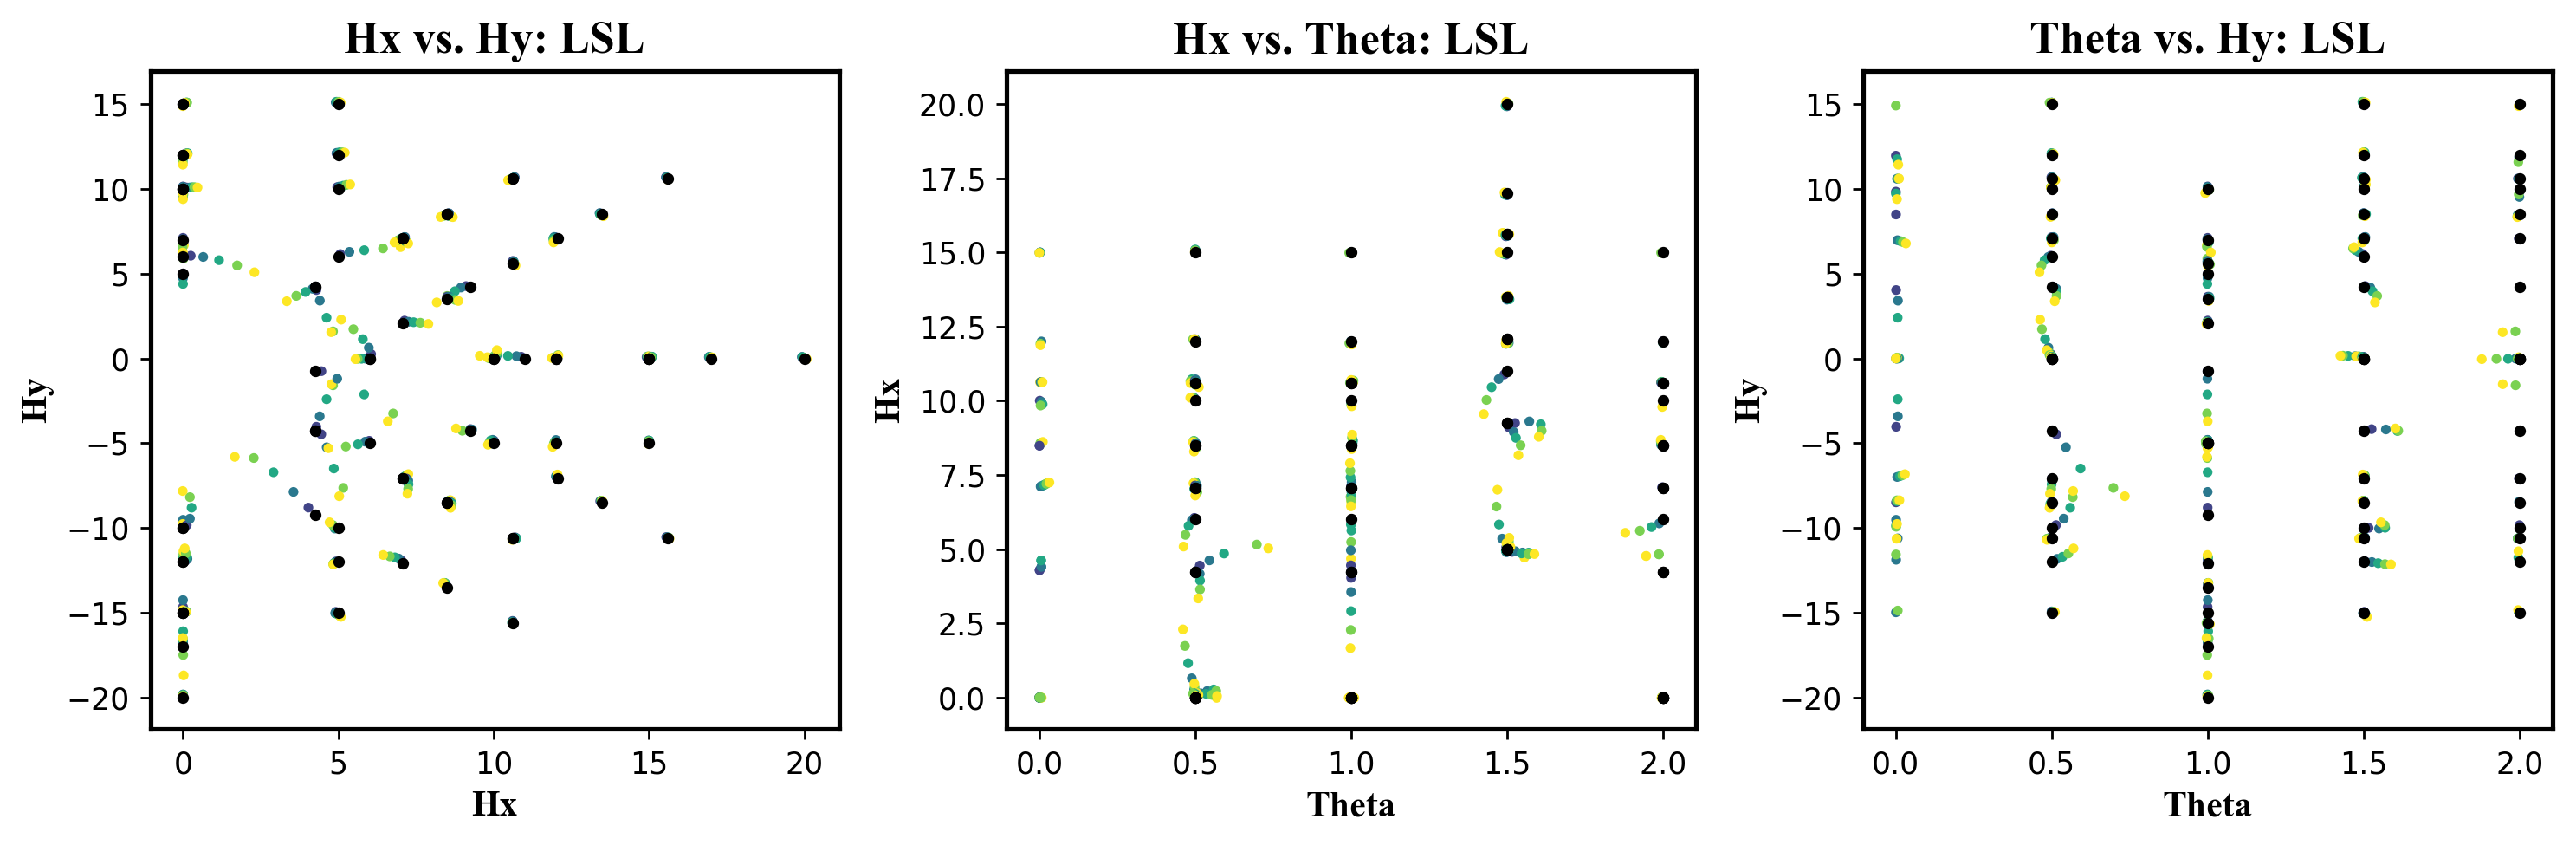

About to exit PlotAll
data length =  74


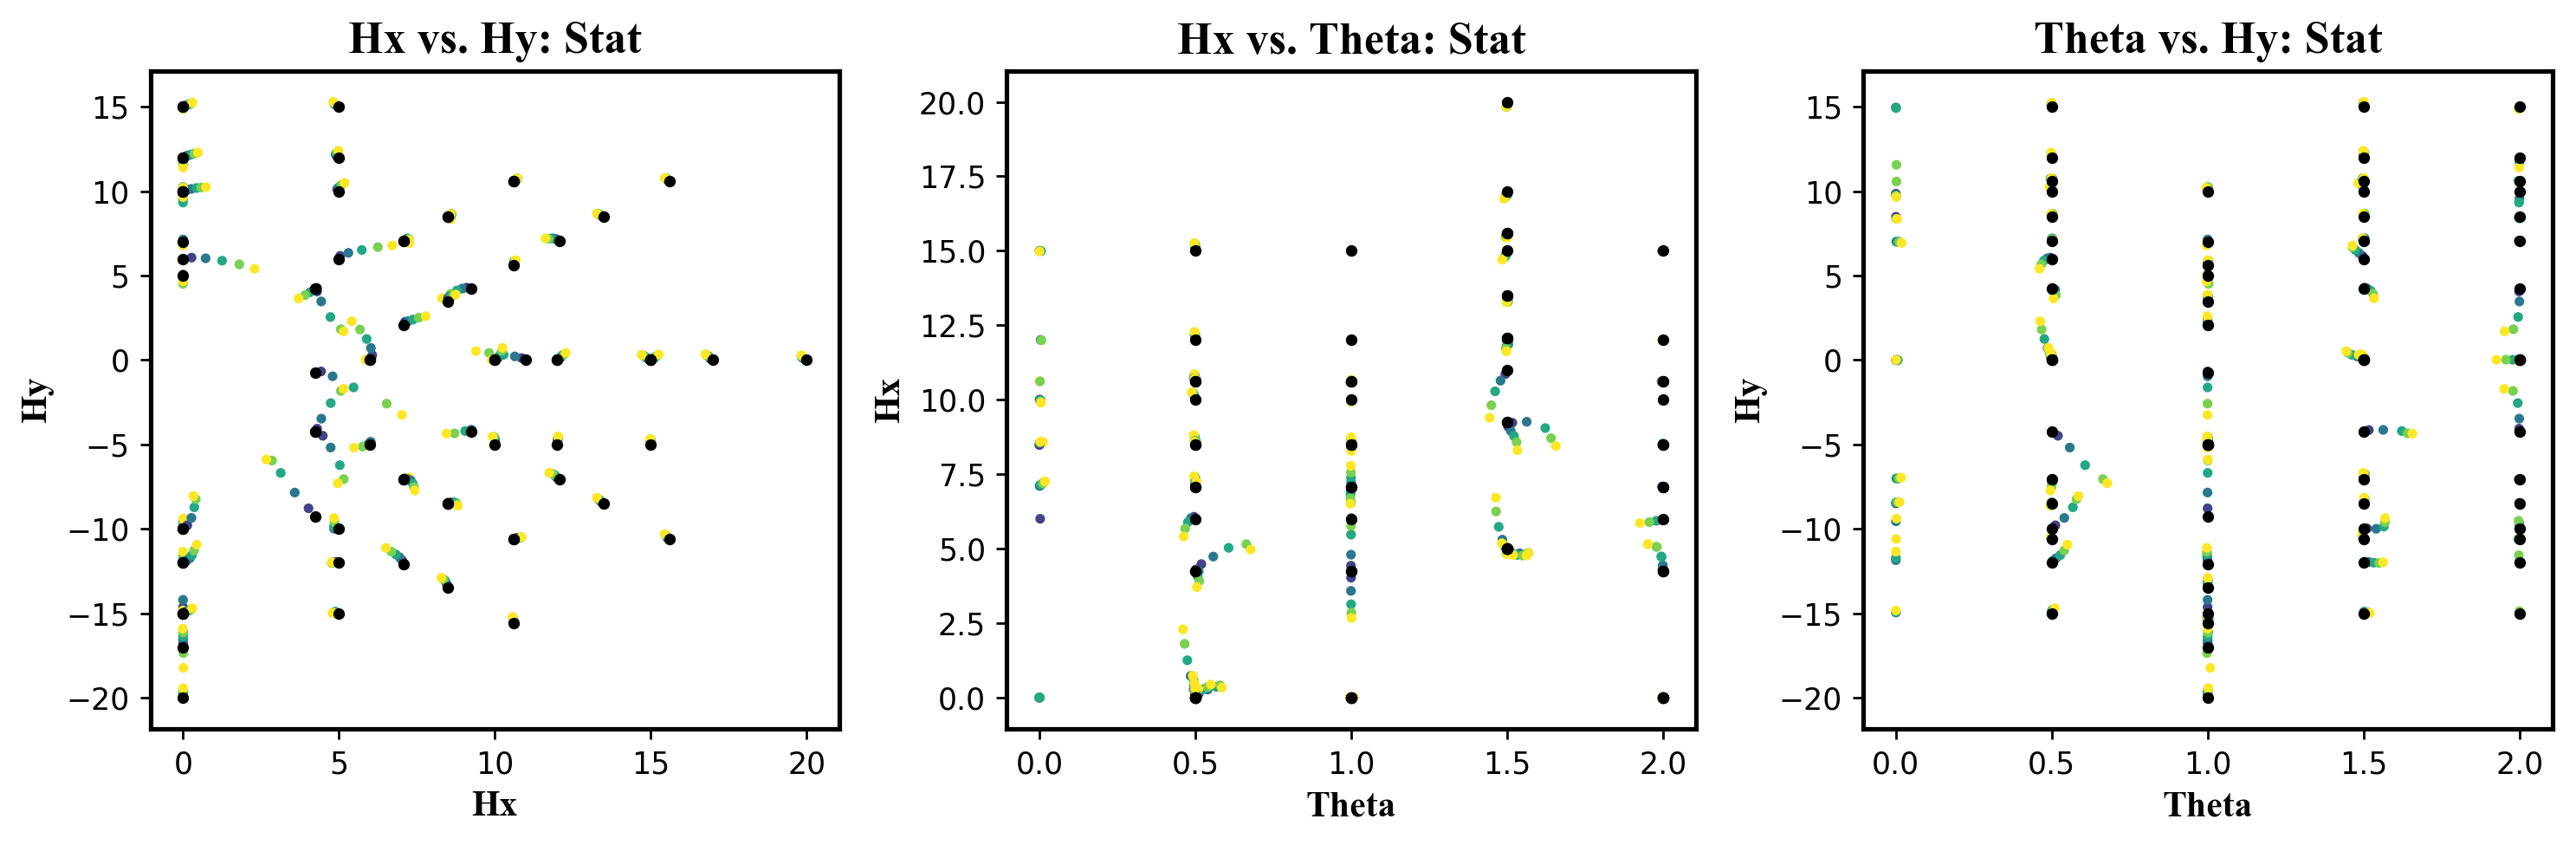

About to exit PlotAll


In [88]:
%matplotlib inline
def PlotPhaseSpace(data,name,var1,var2,var3):
    #global figAll,axAll

    #Figure with every pt for each Re
    csfont = {'fontname':'Times New Roman'}
    fig, ax = plt.subplots(nrows=1,ncols=3,num=1,figsize=(12,4),dpi=250)
    #Hx and Hy Phase Space
    ax[0].set_title(var1+' vs. '+var2+': '+name,fontsize=15,**csfont)
    ax[0].set_xlabel(var1,fontsize=12,**csfont)
    ax[0].set_ylabel(var2,fontsize=12,**csfont)
    #Hx and Theta Phase Space
    ax[1].set_title(var1+' vs. '+var3+': '+name,fontsize=15,**csfont)
    ax[1].set_xlabel(var3,fontsize=12,**csfont)
    ax[1].set_ylabel(var1,fontsize=12,**csfont)
    #Hy and Theta Phase Space
    ax[2].set_title(var3+' vs. '+var2+': '+name,fontsize=15,**csfont)
    ax[2].set_xlabel(var3,fontsize=12,**csfont)
    ax[2].set_ylabel(var2,fontsize=12,**csfont)
    
    print('data length = ',len(data))
    for idx in range(len(data)):
        #print('idx = ',idx)
        tempData = data[idx].copy()
        val1 = tempData[var1]
        val2 = tempData[var2]
        val3 = tempData[var3]
        time = tempData['time']
        #GENERATE FIGURE
        #Hx and Hy Phase Space
        ax[0].scatter(val1[0],val2[0],c='k',s=8,zorder=5)
        ax[0].scatter(val1[1:],val2[1:],c=time[1:],cmap='viridis',s=5,vmin=0.0,vmax=0.5)
        #ax[0].scatter(val1[0],val2[0],c='k',s=5,zorder=5)
        #ax[0].scatter(val1[1:],val2[1:],c=Theta[1:],cmap='viridis',s=5,vmin=0.0,vmax=2.0)
        #Theta and Hx Phase Space
        ax[1].scatter(val3[0],val1[0],c='k',s=8,zorder=5)
        ax[1].scatter(val3[1:],val1[1:],c=time[1:],cmap='viridis',s=5,vmin=0.0,vmax=0.5)
        #ax[1].scatter(val3[0],val1[0],c='k',s=5,zorder=5)
        #ax[1].scatter(val3[1:],val1[1:],c=Theta[1:],cmap='viridis',s=5,vmin=0.0,vmax=2.0)
        #Theta and Hy Phase Space
        ax[2].scatter(val3[0],val2[0],c='k',s=8,zorder=5)
        ax[2].scatter(val3[1:],val2[1:],c=time[1:],cmap='viridis',s=5,vmin=0.0,vmax=0.5)
        #ax[2].scatter(val3[0],val2[0],c='k',s=5,zorder=5)
        #ax[2].scatter(val3[1:],val2[1:],c=Theta[1:],cmap='viridis',s=5,vmin=0.0,vmax=2.0)
        
    #ax[0].axis([-20.0,20.0,-20.0,20.0])
    #ax[1].axis([-0.1,2.1,-1.0,20.0])
    #ax[2].axis([-0.1,2.1,-20.0,20.0])
    fig.tight_layout()
    plt.show()
    fig.savefig(cwd_PYTHON+'/../HThetaPlots/3Plots_Init'+name+'.png')
    #figAll.savefig(cwd_PYTHON + '/../HThetaPlots/Periodic/HThetaAll_InitLast_'+name+'.png')
    fig.clf()
    plt.close()
    print('About to exit PlotAll')

    return

#For each Reynolds number (aka Swim Direction)
for idxRe in range(len(SwimDirList)):
    PlotPhaseSpace(allData[idxRe],SwimDirList[idxRe],'Hx','Hy','Theta')
    #PlotPhaseSpace(allData[idxRe],SwimDirList[idxRe],'H','Theta_a','Theta_b')

### Create a 3D plot containing vector field data for (dHx, dHy, dTheta)
#### Set bounds on Theta coordinate to be (-pi/6,5pi/6) or something like that to keep Theta = 0, 2pi around same place

data length =  74


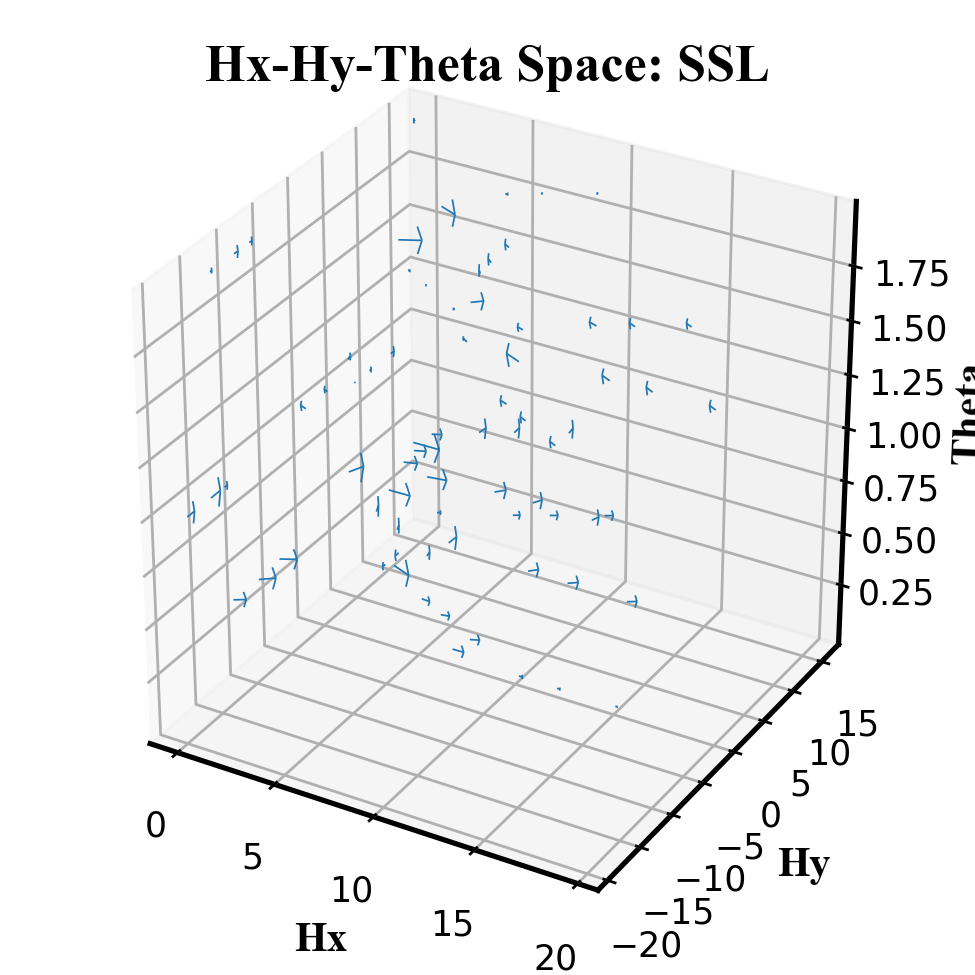

About to exit PlotAll
data length =  74


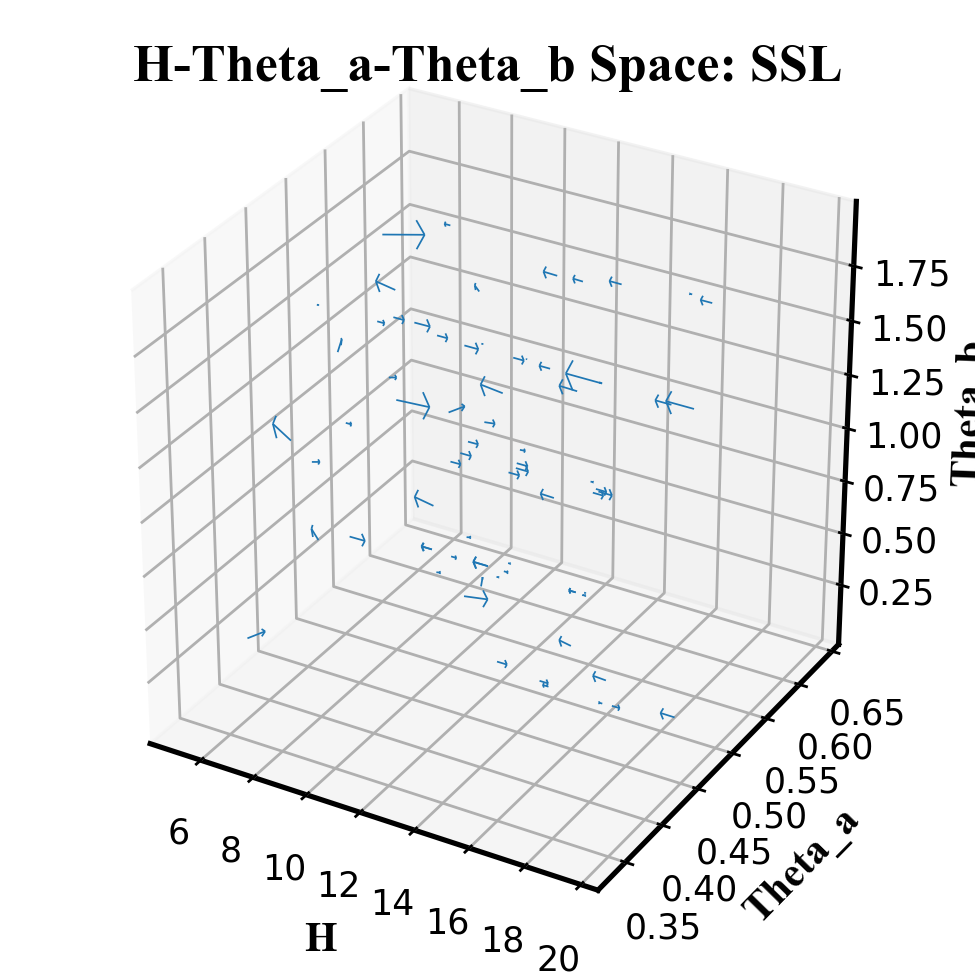

About to exit PlotAll
data length =  74


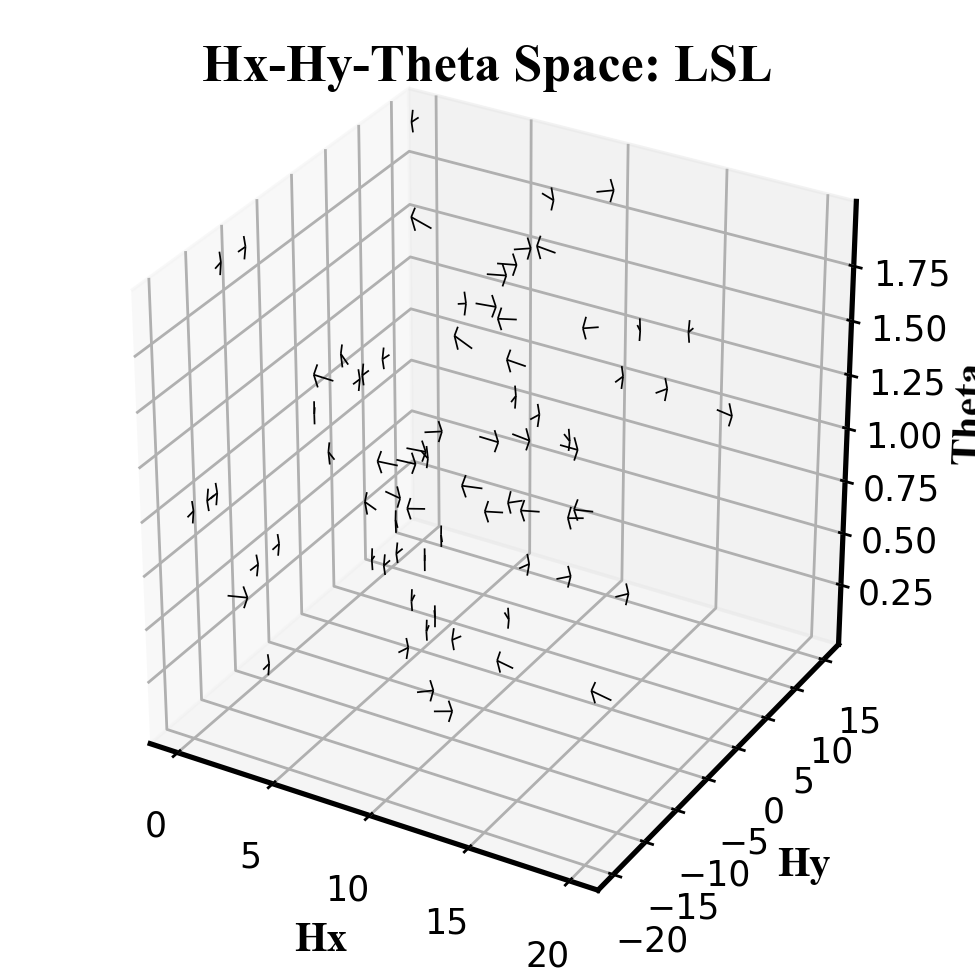

About to exit PlotAll
data length =  74


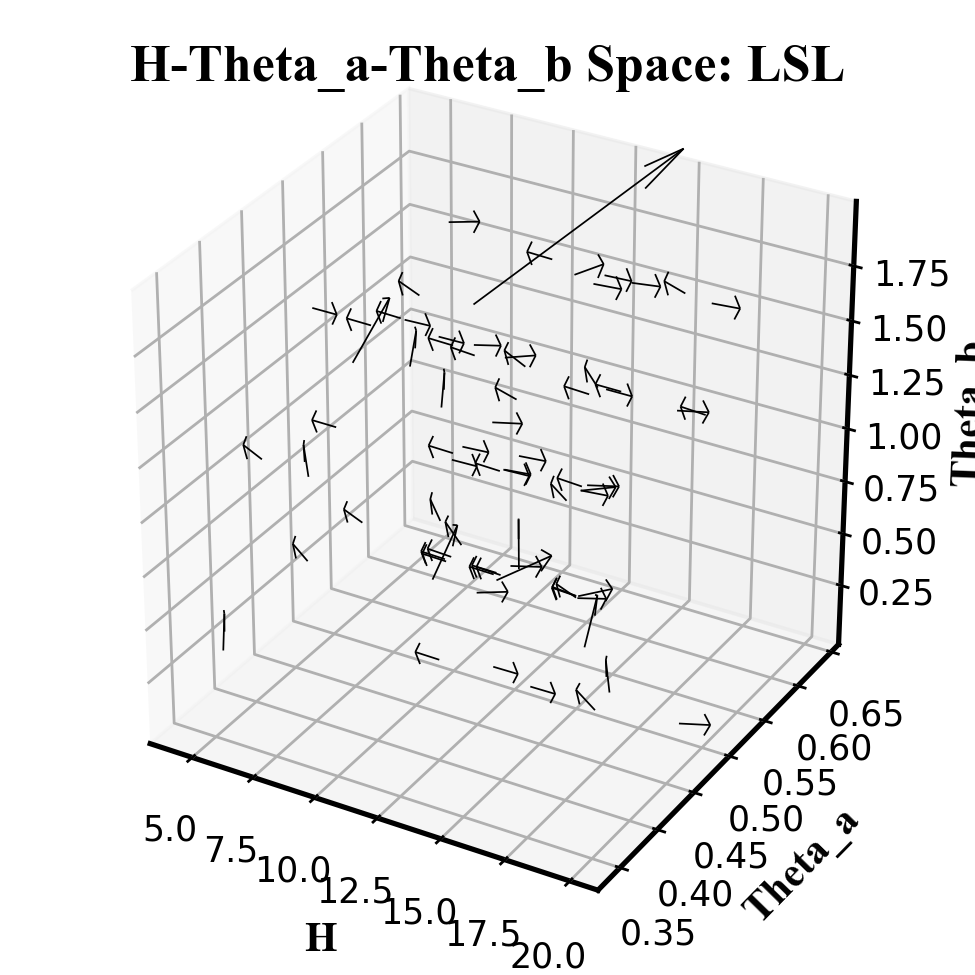

About to exit PlotAll
data length =  74


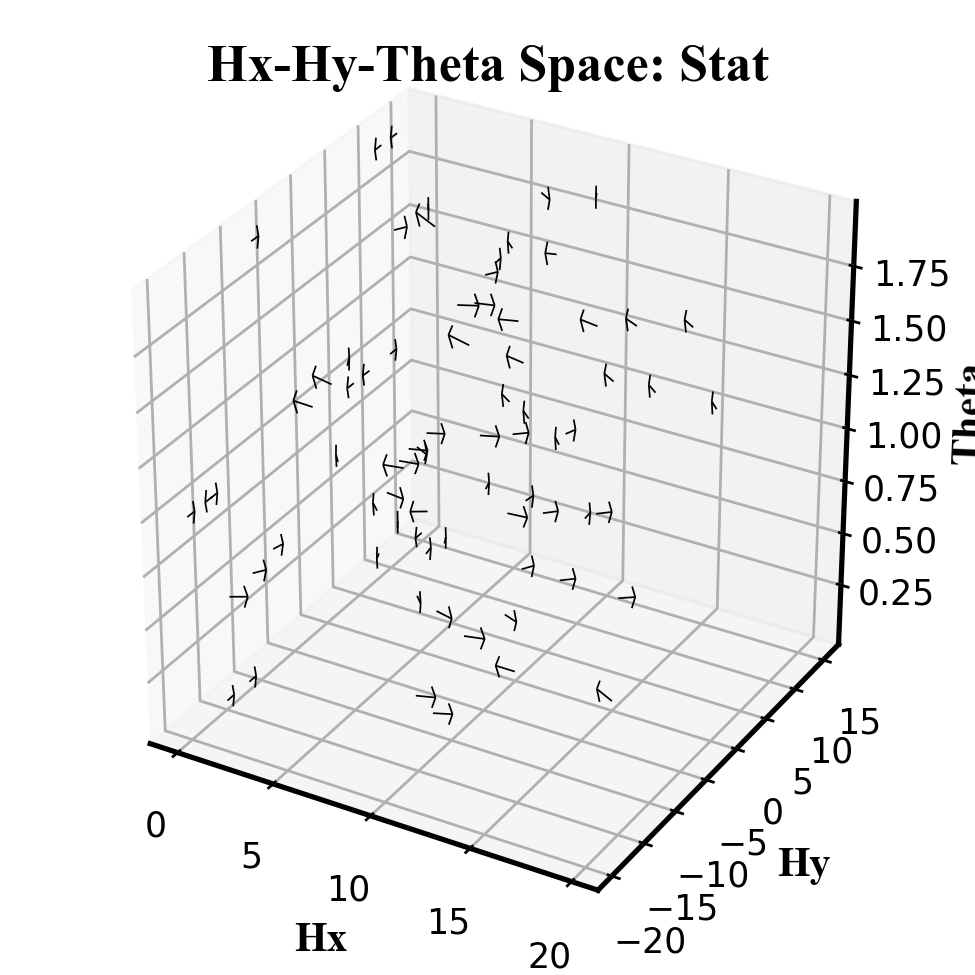

About to exit PlotAll
data length =  74


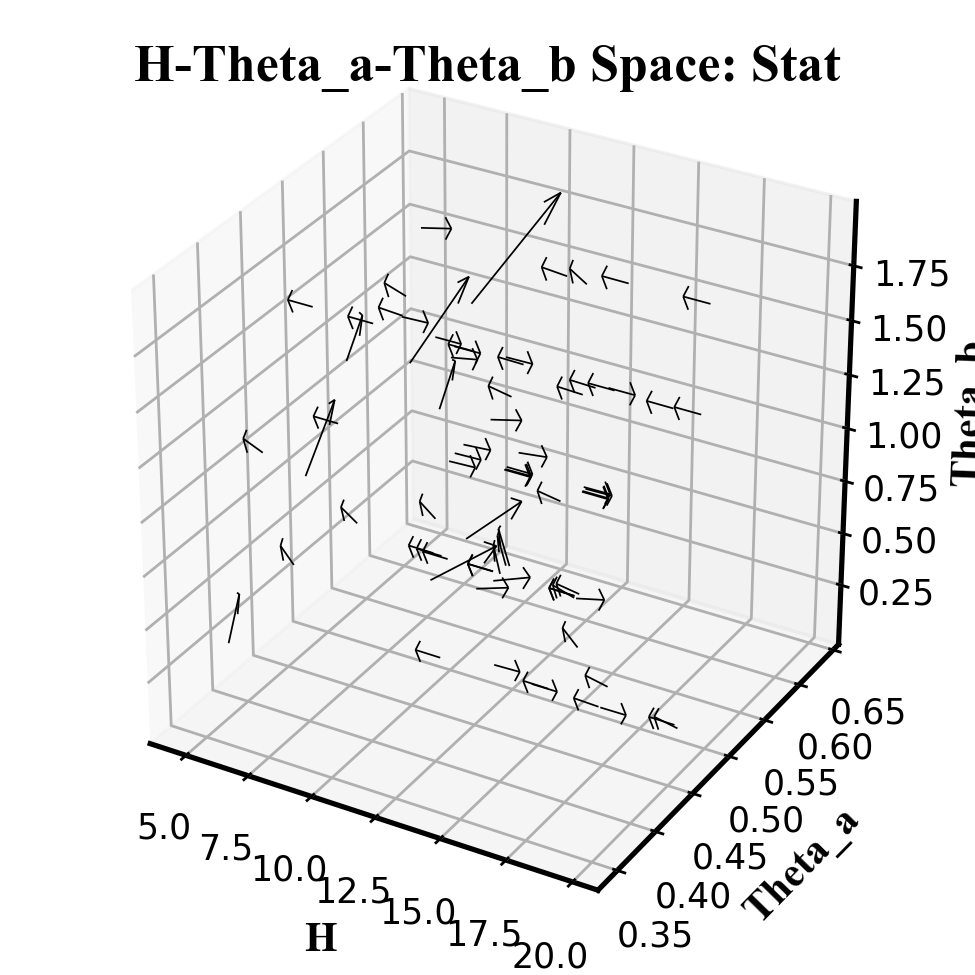

About to exit PlotAll


In [86]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline
def Plot3DPhaseSpace(data,name,var1,var2,var3,var4,var5,var6):
    #global figAll,axAll

    #Figure with every pt for each Re
    csfont = {'fontname':'Times New Roman'}
    figAll = plt.figure(num=1,figsize=(4,4),dpi=250)
    #figAll, axAll = plt.subplots(nrows=1, ncols=1,num=0,figsize=(16,16),dpi=250)
    axAll = figAll.gca(projection='3d')
    axAll.set_title(var1+'-'+var2+'-'+var3+' Space: '+name,fontsize=15,**csfont)
    axAll.set_zlabel(var3,fontsize=12,**csfont)
    axAll.set_ylabel(var2,fontsize=12,**csfont)
    axAll.set_xlabel(var1,fontsize=12,**csfont)
    
    print('data length = ',len(data))
    for idx in range(0,len(data)):
        #print('idx = ',idx)
        tempData = data[idx].copy()
        val1 = tempData.loc[3,var1]
        val2 = tempData.loc[3,var2]
        val3 = tempData.loc[3,var3]
        val4 = np.mean(tempData[var4])
        #print('dHx: ',dHx)
        #print('dHxMax: ',np.amax(abs(tempData['dHx'])))
        val5 = np.mean(tempData[var5])
        #print('dHy: ',dHy)
        #print('dHyMax: ',np.amax(abs(tempData['dHy'])))
        val6 = np.mean(tempData[var6])
        #print('dTheta: ',dTheta)
        #print('dThetaMax: ',np.amax(abs(tempData['dTheta'])))
        time = tempData['time']
        '''if(np.amax(dTheta) < 0.5):
        
            #Check for NaN values
            if np.isnan(np.sum(dHx)):
                print('dHx has NaN')
                dHx = dHx[np.isfinite(dHx)] # just remove nan elements from vector
            #dHx[dHx > 0.5] = 0.0
            if np.isnan(np.sum(dHy)):
                print('dHy has NaN')
                dHy = dHy[np.isfinite(dHy)] # just remove nan elements from vector
            #dHy[dHy > 0.5] = 0.0
            if np.isnan(np.sum(dTheta)):
                print('dTheta has NaN')
                dTheta = dTheta[np.isfinite(dTheta)] # just remove nan elements from vector
            #dTheta[dTheta > 0.5] = 0.0'''
        
        #GENERATE FIGURE
        if(name == 'SSL'):
            axAll.quiver(val1, val2, val3, 
                         val4, val5, val6,
                         cmap='viridis',length=3, arrow_length_ratio=0.2,normalize=False,lw=0.5)
        elif(name=='LSL'):
            axAll.quiver(val1, val2, val3, 
                         val4, val5, val6,
                         color='k',length=1, arrow_length_ratio=0.2,normalize=True,lw=0.5)
        else:
            axAll.quiver(val1, val2, val3, 
                         val4, val5, val6,
                         color='k',length=1, arrow_length_ratio=0.2,normalize=True,lw=0.5)
    
    #axAll.set_xlim(-1.0,20.0)
    #axAll.set_ylim(-20.0,20.0)
    #axAll.set_zlim(-0.1,2.1)
    #axAll.view_init(elev=0., azim=90)
    figAll.tight_layout()
    plt.show()
    #figAll.savefig(cwd_PYTHON + '/../HThetaPlots/Periodic/HThetaAll_InitLast_'+name+'.png')
    figAll.clf()
    plt.close()
    print('About to exit PlotAll')

    return

for idxRe in range(len(SwimDirList)):
    Plot3DPhaseSpace(allData[idxRe],SwimDirList[idxRe],'Hx','Hy','Theta','dHx','dHy','dTheta')
    Plot3DPhaseSpace(allData[idxRe],SwimDirList[idxRe],'H','Theta_a','Theta_b','dH','dTheta_a','dTheta_b')

#### Create Movies Showing Phase Space Evolution

In [41]:
def PlotPhaseSpaceMovie(data,name):
    #global figAll,axAll

    #Figure with every pt for each Re
    #Figure with every pt for each Re
    csfont = {'fontname':'Times New Roman'}
    fig = plt.figure(num=1,figsize=(12,4),dpi=250)
    
    #Data is from each sim
    #Need to figure out a way to get the zeroth timestep value of each simulation
    #Then I need to do this for all timesteps
    #First I need to concatenate all the data...
    #Then I need to sort by time
    #Then I choose a loop over time values and plot them all
    
    everyDict = {'Theta':[],'Hx':[],'Hy':[],'time':[]}
    everyData = pd.DataFrame(data=everyDict)
    for idx in range(len(data)):
        #If simulation ended before 20s, add last timestep pts till 20s
        tempData = data[idx].copy()
        nTime = len(tempData['time'])
        if(201 - nTime > 0):
            print('simulation ended early: idx = ',idx)
            #Sim ended early
            count = 201 - nTime
            for idxCount in range(count):
                tempData.loc[nTime+idxCount,'Hx'] = tempData.loc[nTime-1,'Hx']
                tempData.loc[nTime+idxCount,'Hy'] = tempData.loc[nTime-1,'Hy']
                tempData.loc[nTime+idxCount,'Theta'] = tempData.loc[nTime-1,'Theta']
                tempData.loc[nTime+idxCount,'time'] = tempData.loc[nTime-1,'time']+(idxCount+1)*PERIOD
        everyData = pd.concat([everyData,tempData],ignore_index=True)
    everyData.sort_values(by=['time'])
    everyData.reset_index(drop=True)
    
    for idxTime in range(201):
        #Hx and Hy Phase Space
        ax0 = fig.add_subplot(131)
        ax0.set_title(r'$H_y$ vs. $H_x$: '+name,fontsize=15,**csfont)
        ax0.set_xlabel(r'$H_x/R$ (m)',fontsize=12,**csfont)
        ax0.set_ylabel(r'$H_y$/R (m)',fontsize=12,**csfont)
        #Hx and Theta Phase Space
        ax1 = fig.add_subplot(132)
        ax1.set_title(r'$H_x$ vs. $\Theta$: '+name,fontsize=15,**csfont)
        ax1.set_xlabel(r'$\Theta/\pi$',fontsize=12,**csfont)
        ax1.set_ylabel(r'$H_x$/R (m)',fontsize=12,**csfont)
        #Hy and Theta Phase Space
        ax2 = fig.add_subplot(133)
        ax2.set_title(r'$H_y$ vs. $\Theta$: '+name,fontsize=15,**csfont)
        ax2.set_xlabel(r'$\Theta/\pi$',fontsize=12,**csfont)
        ax2.set_ylabel(r'$H_y$/R (m)',fontsize=12,**csfont)
        timeValue = idxTime*PERIOD
        initData = everyData[everyData['time'] == 0.0].copy()
        tempData = everyData[everyData['time'] <= timeValue+0.001].copy()
        tempData = tempData[tempData['time'] >= timeValue - 0.001].copy()
        Hx = tempData['Hx']/RADIUSLARGE
        Hy = tempData['Hy']/RADIUSLARGE
        Theta = tempData['Theta']/np.pi
        time = tempData['time']
        #GENERATE FIGURE
        if(timeValue == 0.0):
            ax0.scatter(initData['Hx']/RADIUSLARGE,initData['Hy']/RADIUSLARGE,c='k',s=9)
            ax1.scatter(initData['Theta']/np.pi,initData['Hx']/RADIUSLARGE,c='k',s=9)
            ax2.scatter(initData['Theta']/np.pi,initData['Hy']/RADIUSLARGE,c='k',s=9)
        if(timeValue != 0.0):
            ax0.scatter(Hx,Hy,c=Theta,cmap='viridis',s=9,vmin=0.0,vmax=2.0)
            ax1.scatter(Theta,Hx,c=Theta,cmap='viridis',s=9,vmin=0.0,vmax=2.0)
            ax2.scatter(Theta,Hy,c=Theta,cmap='viridis',s=9,vmin=0.0,vmax=2.0)
        ax0.axis([-10.0,10.0,-10.0,10.0])
        ax1.axis([-0.1,2.1,-10.0,10.0])
        ax2.axis([-0.1,2.1,-10.0,10.0])
        fig.tight_layout()
        figName = cwd_PYTHON + '/../HThetaPlots/Periodic/PhaseSpaceMovie/'+name+'/PhaseSpaceMovie_'+name
        fig.savefig(figName+'_%03d.png' % idxTime)
        fig.clf()
        
    plt.close()
    print('About to exit PlotAll')

    return

#For each Reynolds number (aka Swim Direction)
for idxRe in range(len(SwimDirList)):
    PlotPhaseSpaceMovie(allData[idxRe],SwimDirList[idxRe])
    #Make a Movie!
    os.chdir(cwd_PYTHON + '/../HThetaPlots/Periodic/PhaseSpaceMovie/'+SwimDirList[idxRe]+'/')
    if(idxRe == 0):
        !pwd
        !ffmpeg -r 15 -i PhaseSpaceMovie_SSL_%03d.png -vcodec libx264 -pix_fmt yuv420p -y PhaseSpaceMovie_SSL.mp4
    elif(idxRe == 1):
        !ffmpeg -r 15 -i PhaseSpaceMovie_LSL_%03d.png -vcodec libx264 -pix_fmt yuv420p -y PhaseSpaceMovie_LSL.mp4
    elif(idxRe == 2):
        !ffmpeg -r 15 -i PhaseSpaceMovie_Stat_%03d.png -vcodec libx264 -pix_fmt yuv420p -y PhaseSpaceMovie_Stat.mp4
    os.chdir(cwd_PYTHON)

simulation ended early: idx =  1
simulation ended early: idx =  4
simulation ended early: idx =  5
simulation ended early: idx =  8
simulation ended early: idx =  12
simulation ended early: idx =  18
simulation ended early: idx =  19
simulation ended early: idx =  33
simulation ended early: idx =  38
simulation ended early: idx =  54
simulation ended early: idx =  55
simulation ended early: idx =  58
simulation ended early: idx =  59
simulation ended early: idx =  62
simulation ended early: idx =  63
simulation ended early: idx =  66
simulation ended early: idx =  67
simulation ended early: idx =  70
simulation ended early: idx =  71
simulation ended early: idx =  72
About to exit PlotAll
/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/PhaseSpaceMovie/SSL
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.39.2)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --en

frame=  201 fps= 24 q=-1.0 Lsize=     991kB time=00:00:13.20 bitrate= 614.7kbits/s speed=1.55x     
video:987kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.315091%
[libx264 @ 0x7f9e14048200] frame I:1     Avg QP:21.10  size: 50304
[libx264 @ 0x7f9e14048200] frame P:57    Avg QP:20.93  size:  7286
[libx264 @ 0x7f9e14048200] frame B:143   Avg QP:25.78  size:  3810
[libx264 @ 0x7f9e14048200] consecutive B-frames:  2.0%  5.0% 13.4% 79.6%
[libx264 @ 0x7f9e14048200] mb I  I16..4: 18.3% 70.7% 11.0%
[libx264 @ 0x7f9e14048200] mb P  I16..4:  0.5%  1.6%  0.8%  P16..4:  2.7%  1.0%  0.5%  0.0%  0.0%    skip:93.0%
[libx264 @ 0x7f9e14048200] mb B  I16..4:  0.1%  0.2%  0.2%  B16..8:  4.7%  1.2%  0.3%  direct: 0.1%  skip:93.3%  L0:52.7% L1:45.0% BI: 2.4%
[libx264 @ 0x7f9e14048200] 8x8 transform intra:56.9% inter:32.2%
[libx264 @ 0x7f9e14048200] coded y,uvDC,uvAC intra: 12.1% 22.0% 21.2% inter: 0.6% 1.2% 0.9%
[libx264 @ 0x7f9e14048200] i16 v,h,dc,p: 56% 41%  3%  0%
[l

#### Movies are shown below!

In [42]:
from IPython.display import Video
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/PhaseSpaceMovie/SSL/PhaseSpaceMovie_SSL.mp4" ./PhaseSpaceMovie_SSL.mp4
Video('PhaseSpaceMovie_SSL.mp4',embed=True)

In [43]:
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/PhaseSpaceMovie/Stat/PhaseSpaceMovie_Stat.mp4" ./PhaseSpaceMovie_Stat.mp4
Video('PhaseSpaceMovie_Stat.mp4')

In [44]:
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/PhaseSpaceMovie/LSL/PhaseSpaceMovie_LSL.mp4" ./PhaseSpaceMovie_LSL.mp4
Video('PhaseSpaceMovie_LSL.mp4')